# ECANet通道注意力机制

建模出不同通道之间的相关性，通过网络学习的方式来自动获取到每个特征通道的重要程度，最后再为每个通道赋予不同的权重系数，从而来强化重要的特征抑制非重要的特征。
SENet中的降维会给通道注意力机制带来副作用，捕获所有通道之间的依存关系是效率不高的且是不必要的。

## 1. 计算过程

* 1. 全局平均池化

    将每个通道的二维特征(H*W)压缩为1个实数，将特征图从 (B, C, H, W) ----> (B, C, 1, 1)

* 2. 计算自适应卷积核的大小

    $k = |\frac{log_2(C)}{r} + \frac{b}{r}|$ 其中C为输入的通道数，b=1， r=2

* 3. 给每个特征通道生成一个权重值

    通过两个1x1卷积层构建通道间的相关性，输出的权重值数目和输入特征图的通道数相同

* 3. 归一化权重加权到每个通道的特征上

    逐通道乘以权重系数

## 2. 代码实现

In [1]:
import math
from torch import nn


class ECABlock(nn.Module):
    """通道注意力机制

    Args:
        nn (_type_): _description_
    """

    def __init__(self, channel, gamma=8, b=1):
        super(ECABlock, self).__init__()

        kernel_size = int(abs((math.log(channel, 2) + b) / gamma))
        kernel_size = kernel_size if kernel_size % 2 else kernel_size + 1

        # 先在H*W维度进行压缩，全局平均池化将每个通道平均为一个值
        # (B, C, H, W) ---- (B, C, 1, 1)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)  # 自适应全局池化
        
        # (B, C, 1, 1) ---- (B, 1, C) --- (B, C, 1, 1) --- sigmoid
        self.fc1 = nn.Sequential(
            nn.Conv1d(1, 1, kernel_size=kernel_size , padding=(kernel_size - 1) // 2, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        (b, c, _, _) = x.shape
        y = self.avg_pool(x).view(b, 1, c)
        y_out = self.fc1(y).view(b, c, 1, 1)
        return x * y_out

## 3. 示例

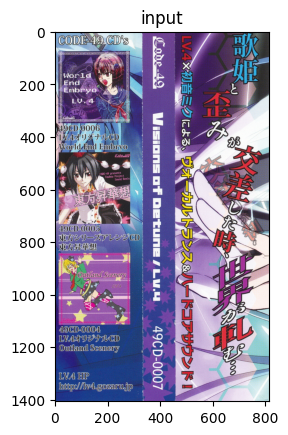

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


frame: (1406, 816, 3)
x: torch.Size([1, 3, 1406, 816])
y: torch.Size([1, 3, 1406, 816])
out: torch.Size([1406, 816, 3])


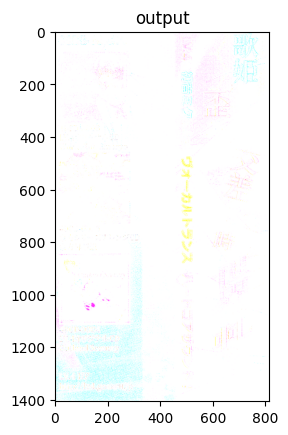

In [2]:
import cv2
import torch
from matplotlib import pyplot as plt

frame = cv2.imread('../images/image2.jpg')
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame)
plt.title('input')
plt.show()


print('frame:', frame.shape) # (H, W, C)

x = torch.Tensor(frame)
x = x.permute(2, 0, 1) # (C, H, W)
x = x[None, :] # (B, C, H, W)
print("x:", x.shape)

block = ECABlock(3)
y = block.forward(x/20)
print("y:", y.shape) # (B, C, H, W)

out = y.squeeze().permute(1, 2, 0) # (H, W, C)
print("out:", out.shape)

plt.title('output')
plt.imshow(out.detach().numpy())
plt.show()
